# Importing packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

Loading the data and checking top 5 records

In [2]:
data = pd.read_csv(r'/content/drive/MyDrive/Documents/Machine Learning/Time Series/jena_climate_2009_2016.csv')
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


The Date Time column has to be formatted as a datetime datatype and set to be in the index. Afterwards, the data will have to be resampled for hourly records.

In [3]:
data['Date Time'] = pd.to_datetime(data['Date Time'], format = "mixed")
data.set_index('Date Time', inplace = True)
df = data.resample('h').mean()

# Data Visualization

Due to the data being big, I filter only the 2009 data to plot and see how the temperature lineplot looks.

<Axes: xlabel='Date Time'>

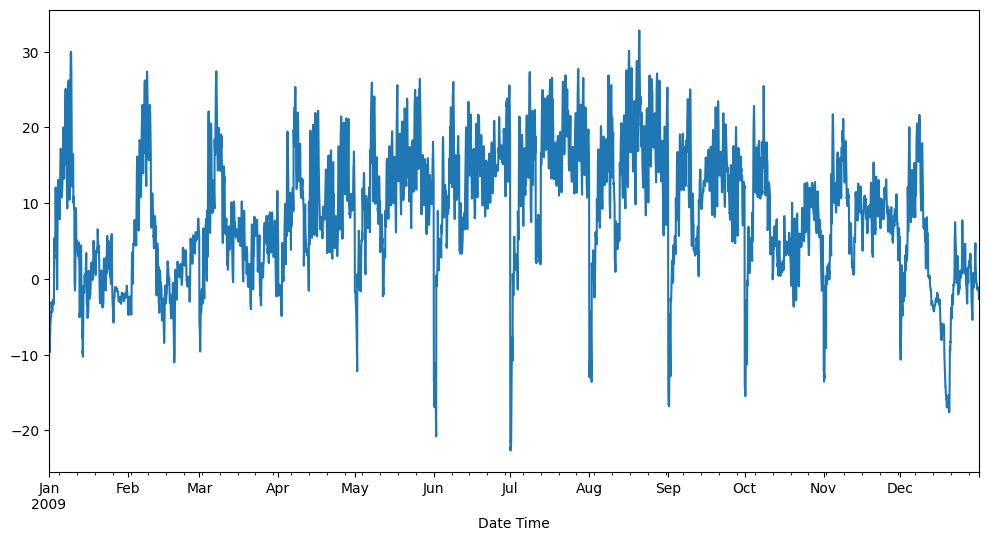

In [4]:
# visualize 2009 Temperature
temp = df.loc[(df.index.year == 2009)]
temp['T (degC)'].plot(figsize = (12, 6))

Let's plot the data correlation to see which features have strong correlation to the temperature. This is **Feature Selection**.

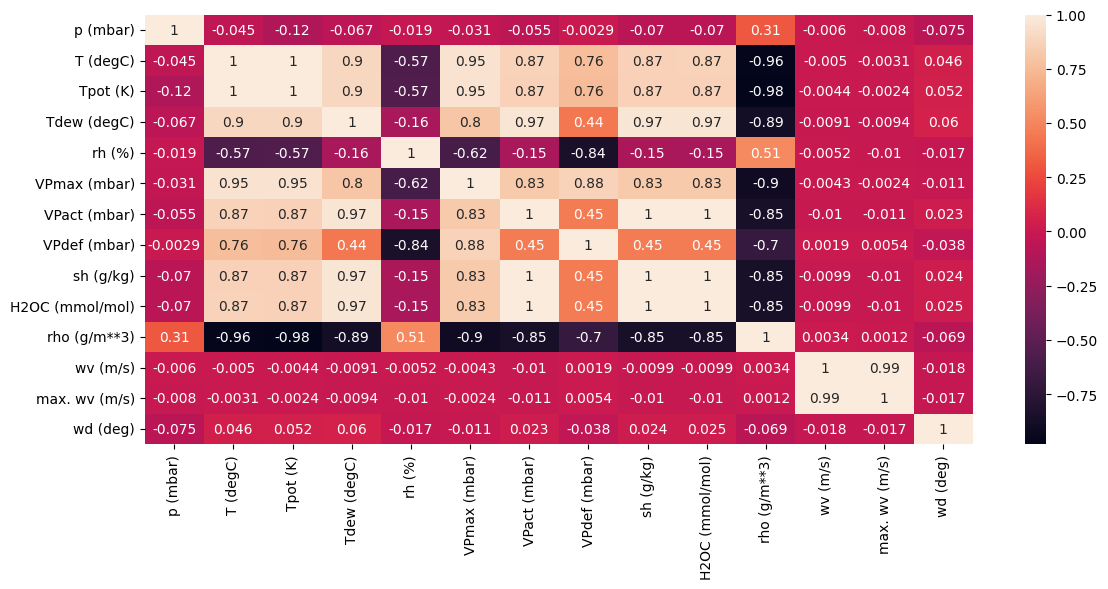

In [13]:
plt.figure(figsize = (12, 6))
sns.heatmap(df.corr(), annot = True)
plt.tight_layout()
plt.show()

Now that I see which features do not have the highest correlation to the temperature column, I will remove them.

In [5]:
df1 = df.drop(columns = ['p (mbar)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)'])

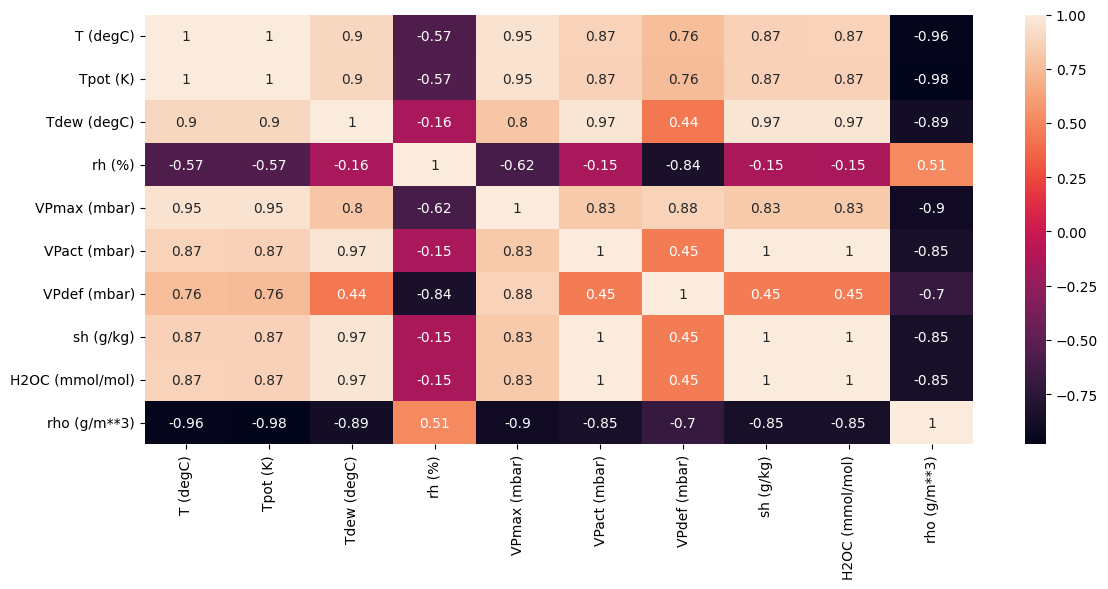

In [ ]:
plt.figure(figsize = (12, 6))
sns.heatmap(df1.corr(), annot = True)
plt.tight_layout()
plt.show()

# Handling Null Values


In [14]:
df1.isnull().sum()

T (degC)           88
Tpot (K)           88
Tdew (degC)        88
rh (%)             88
VPmax (mbar)       88
VPact (mbar)       88
VPdef (mbar)       88
sh (g/kg)          88
H2OC (mmol/mol)    88
rho (g/m**3)       88
dtype: int64

In [15]:
null_df = df1[df1['rh (%)'].isnull() == True]
null_df

,T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3)
Date Time,,,,,,,,,,
2014-09-24 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2016-10-28 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-28 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-28 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I realized that all records with null values were between the dates *24-09-2014* and *28-10-2016*. Now, due to Time Series data being sequential, I have to remove all the data within this period.

In [6]:
df_no_null_1 = df1[df1.index < '2014-09-24 18:00:00']


df_no_null_2 = df1[df1.index > '2016-10-28 11:00:00']               # I can make this the test dataframe


# Preprocessing


In data preprocessing, the data will be properly processed before it can be fed into our models. This involves:


*   separating the input & target variables.
*   Feature Scaling
*   Splitting the data into Train, Validation, and Test sets.
*   Feature Selection, which, in our case, has been performed earlier.









In [16]:
# Data separation into input variables(X)  and  target variable(y)
X = df_no_null_1.drop(columns = 'T (degC)')
y = df_no_null_1['T (degC)']

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

In [9]:
# Data splitting
train_len = round(len(X_scaled) * 0.7)
val_len = round(len(X_scaled) * 0.3)


X_train, y_train = X_scaled[:train_len], y[:train_len]
X_val, y_val = X_scaled[train_len:], y[train_len:]

test_df = df_no_null_2.copy()                             # This is the data that came after the last null value.

X_test = test_df.drop(columns = 'T (degC)')
y_test = test_df['T (degC)']

X_test_scaled = scaler.fit_transform(X_test)


In [10]:
# Instantiate Time Series Generators
train_generator = TimeseriesGenerator(X_train, y_train, length = 10, sampling_rate = 1)
val_generator = TimeseriesGenerator(X_val, y_val, length = 10, sampling_rate = 1)
test_generator = TimeseriesGenerator(X_test_scaled, y_test, length = 10, sampling_rate = 1)

**Building LSTM model**

In [ ]:
lstm_model = keras.Sequential([
              keras.layers.InputLayer(input_shape=(10, 9)),
              keras.layers.LSTM(280),
              keras.layers.Dense(230, activation = keras.layers.LeakyReLU()),
              keras.layers.Dense(180, activation = 'ReLU'),
              keras.layers.Dense(230, activation = 'relu'),
              keras.layers.Dense(210, activation = keras.layers.LeakyReLU()),
              keras.layers.Dense(60, activation = keras.layers.LeakyReLU()),
              keras.layers.Dense(30, activation = keras.layers.LeakyReLU()),
              keras.layers.Dense(70, activation = 'relu'),
              keras.layers.Dense(210, activation = 'tanh'),
              keras.layers.Dense(170, activation = 'tanh'),
              keras.layers.Dense(300, activation = 'tanh'),
              keras.layers.Dense(214, activation = 'relu'),
              keras.layers.Dense(110, activation = 'tanh'),
              keras.layers.Dense(40, activation = 'relu'),
              keras.layers.Dense(60, activation = 'relu'),
              keras.layers.Dense(28, activation = 'relu'),
              keras.layers.Dense(1, activation = 'linear')
                    ])

lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 280)               324800    
                                                                 
 dense_112 (Dense)           (None, 230)               64630     
                                                                 
 dense_113 (Dense)           (None, 180)               41580     
                                                                 
 dense_114 (Dense)           (None, 230)               41630     
                                                                 
 dense_115 (Dense)           (None, 210)               48510     
                                                                 
 dense_116 (Dense)           (None, 60)                12660     
                                                                 
 dense_117 (Dense)           (None, 30)               

In [ ]:
# Define the callbacks

cp = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/ML models/jena_climate_lstm_model.h5', save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience= 6,
                                                  restore_best_weights = True
                                                  )

# compiling model
lstm_model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

In [ ]:
# Fitting the model to train generator
history = lstm_model.fit(train_generator,
                              epochs = 100,
                              validation_data = val_generator,
                              callbacks = [early_stopping, cp]
                              )

Epoch 1/100
275/275 [==============================] - ETA: 0s - loss: 80.2167 - root_mean_squared_error: 8.9564

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - 41s 125ms/step - loss: 80.2167 - root_mean_squared_error: 8.9564 - val_loss: 33.4503 - val_root_mean_squared_error: 5.7836
Epoch 2/100
275/275 [==============================] - 33s 121ms/step - loss: 16.3025 - root_mean_squared_error: 4.0376 - val_loss: 8.3076 - val_root_mean_squared_error: 2.8823
Epoch 3/100
275/275 [==============================] - 33s 120ms/step - loss: 5.7916 - root_mean_squared_error: 2.4066 - val_loss: 3.1079 - val_root_mean_squared_error: 1.7629
Epoch 4/100
275/275 [==============================] - 35s 126ms/step - loss: 3.5695 - root_mean_squared_error: 1.8893 - val_loss: 2.2580 - val_root_mean_squared_error: 1.5027
Epoch 5/100
275/275 [==============================] - 33s 121ms/step - loss: 2.8345 - root_mean_squared_error: 1.6836 - val_loss: 2.1319 - val_root_mean_squared_error: 1.4601
Epoch 6/100
275/275 [==============================] - 34s 125ms/step - loss: 2.6304 - root_mean_squared_error: 1.6218 - val_loss

# Predictions

 Now that the model has been trained, I will make predictions on the Train, Validation, and Test samples.

In [ ]:
train_preds = lstm_model.predict(train_generator)
val_preds = lstm_model.predict(val_generator)
test_preds = lstm_model.predict(test_generator)

# train
train_preds_df = pd.DataFrame(data = train_preds, columns = ['Predicted T (degC)'])
train_preds_df['Date'] = train_len.index[10:len(X)]

# val
val_preds_df = pd.DataFrame(data = val_preds, columns = ['Predicted T (degC)'])
val_preds_df['Date'] = df_no_null_1[train_len + 10: ].index

# test
test_preds_df = pd.DataFrame(data = test_preds, columns = ['Predicted T (degC)'])
test_preds_df['Date'] = test_df.index[10 :]

13/13 [==============================] - 2s 114ms/step


# Evaluation and Plots

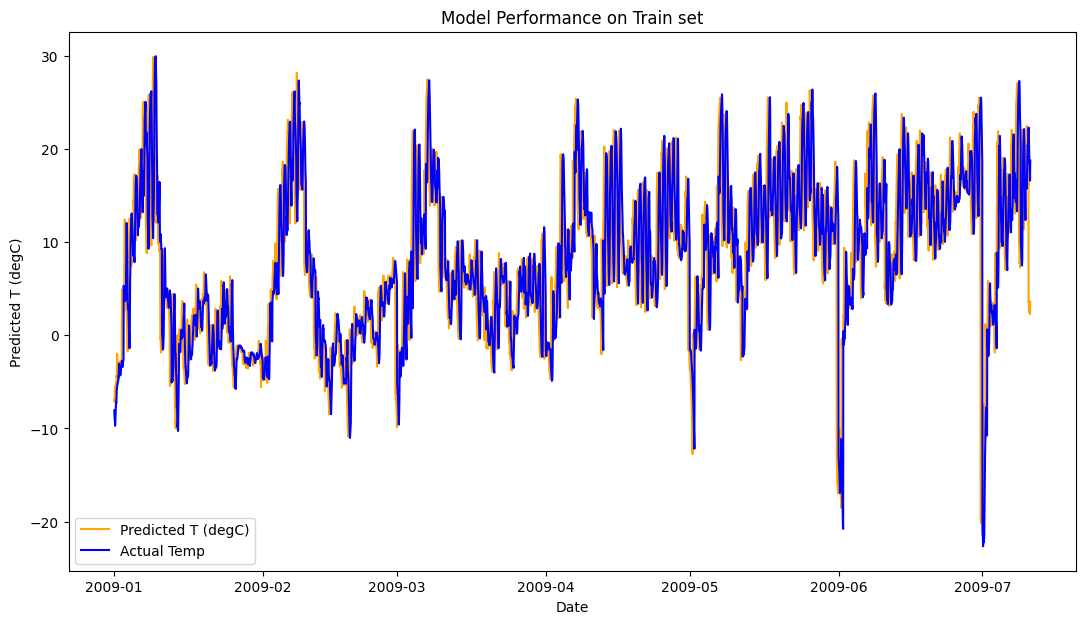

In [ ]:
# Train Plot

plot_sample = df1[(df1.index > '2009-01-01 00:00:00') & (df1.index < '2009-07-11 00:00:00')]
plot_sample_preds = train_preds_df[(train_preds_df['Date'] > '2009-01-01 00:00:00') & (train_preds_df['Date'] < '2009-07-11 00:00:00')]

plt.figure(figsize = (13, 7))
sns.lineplot(data = plot_sample_preds, x = 'Date', y = 'Predicted T (degC)', label = 'Predicted T (degC)', color = 'orange')
sns.lineplot(data = plot_sample.reset_index(), x = 'Date Time', y = 'T (degC)', label = 'Actual Temp', color = 'blue')
plt.title('Model Performance on Train set')
plt.show()

In [ ]:
train_mse, train_rmse = lstm_model.evaluate(train_generator)[0], lstm_model.evaluate(train_generator)[1]

print(f'''Mean Squared Error for train sample = {train_mse}
Root Mean Squared Error for train sample {train_rmse}''')

275/275 [==============================] - 12s 44ms/step - loss: 1.7479 - root_mean_squared_error: 1.3221


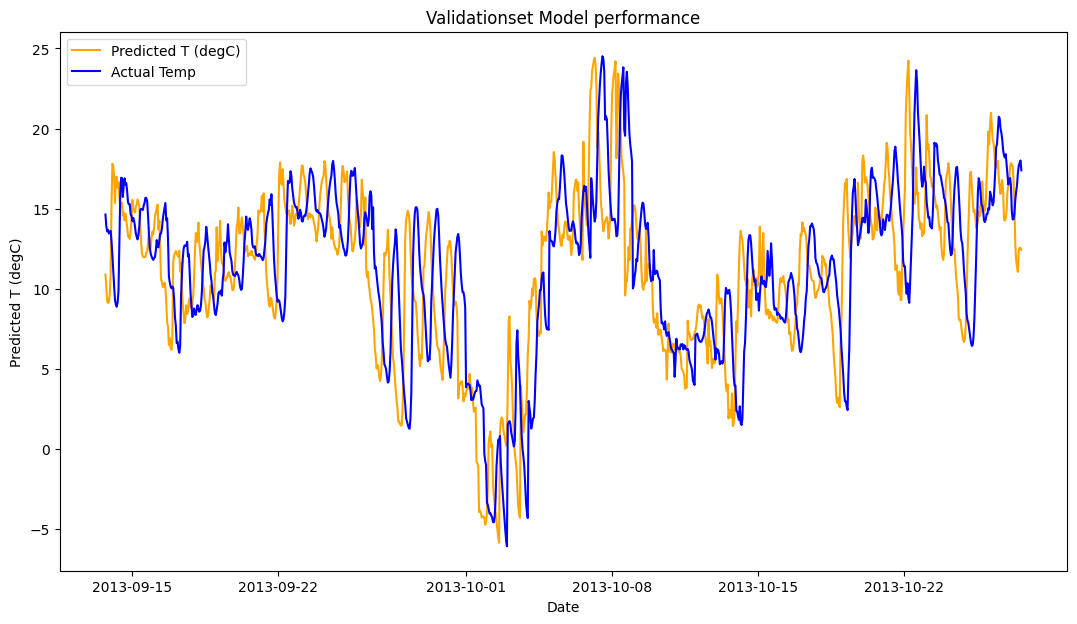

In [ ]:
# val Plot
val_df = df_no_null_1[train_len:-10]


plot_sample = val_df[(val_df.index > '2013-09-13 16:00:00') & (val_df.index < '2013-10-27 16:00:00')]
plot_sample_preds = val_preds_df[(val_preds_df['Date'] > '2013-09-13 16:00:00') & (val_preds_df['Date'] < '2013-10-27 16:00:00')]

plt.figure(figsize = (13, 7))
sns.lineplot(data = plot_sample_preds, x = 'Date', y = 'Predicted T (degC)', label = 'Predicted T (degC)', color = 'orange')
sns.lineplot(data = plot_sample.reset_index(), x = 'Date Time', y = 'T (degC)', label = 'Actual Temp', color = 'blue')
plt.title('Validation set Model performance')
plt.show()

In [17]:
val_mse, val_rmse = lstm_model.evaluate(val_generator)[0], lstm_model.evaluate(val_generator)[1]

print(f'''Mean Squared Error for validation sample = {val_mse}
Root Mean Squared Error for validation sample {val_rmse}''')

Text(0.5, 1.0, 'Test set Model Performance')

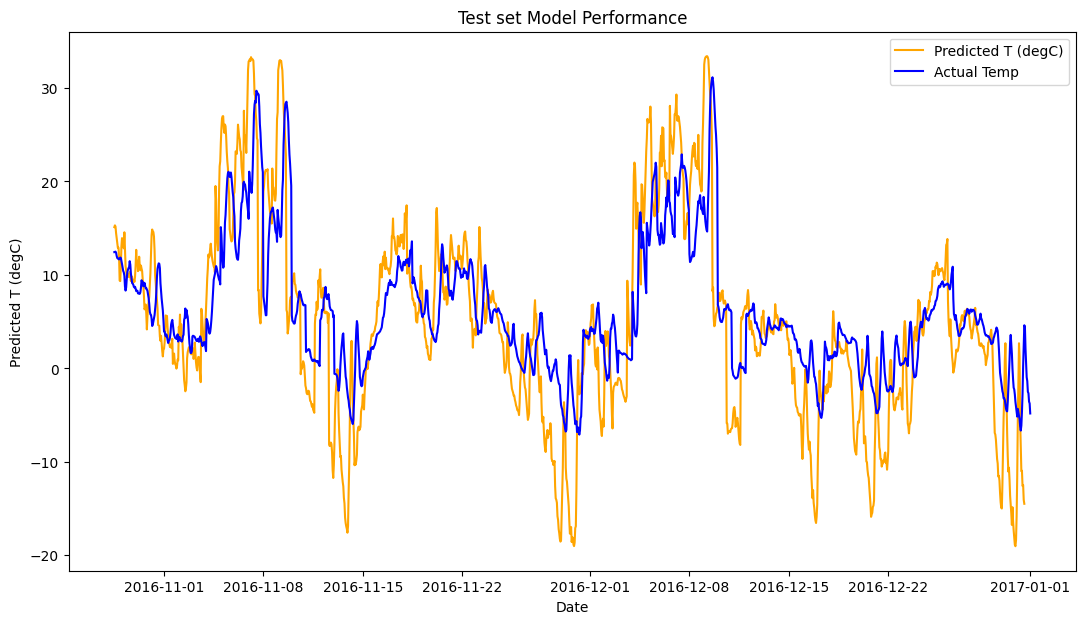

In [ ]:
# test Plot

plot_sample = test_df
plot_sample_preds = test_preds_df

plt.figure(figsize = (13, 7))
sns.lineplot(data = plot_sample_preds, x = 'Date', y = 'Predicted T (degC)', label = 'Predicted T (degC)', color = 'orange')
sns.lineplot(data = plot_sample.reset_index(), x = 'Date Time', y = 'T (degC)', label = 'Actual Temp', color = 'blue')
plt.title('Test set Model Performance')
plt.show()

In [19]:
test_mse, test_rmse = lstm_model.evaluate(test_generator)[0], lstm_model.evaluate(test_generator)[1]

print(f'''Mean Squared Error for test sample = {test_mse}
Root Mean Squared Error for test sample {test_rmse}''')

## Building CNN Model

In [ ]:
cnn_model = keras.Sequential([
    keras.Input(shape=(10, 9)),  # Adjust the input shape
    keras.layers.Conv1D(filters=100, kernel_size=2, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='tanh'),  # Increase the kernel_size to 3
    keras.layers.GlobalAveragePooling1D(),  # Add a GlobalAveragePooling1D layer
    keras.layers.Dense(1, activation='linear')  # Add a Dense layer for the output
])
cnn_model.summary()

# model compiling
cnn_model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError(), MeanSquaredError()])


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_83 (Conv1D)          (None, 9, 100)            1900      
                                                                 
 max_pooling1d_66 (MaxPooli  (None, 4, 100)            0         
 ng1D)                                                           
                                                                 
 conv1d_84 (Conv1D)          (None, 3, 64)             12864     
                                                                 
 global_average_pooling1d_9  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 14829 (57.93 KB)
Trainable params: 1482

In [ ]:
# fitting model
history = cnn_model.fit(train_generator,
                              epochs = 100,
                              validation_data = val_generator,
                              callbacks = [early_stopping, cp]
                              )

Epoch 1/100
275/275 [==============================] - ETA: 0s - loss: 106.1578 - root_mean_squared_error: 10.3033 - mean_squared_error: 106.0264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - 6s 14ms/step - loss: 106.1578 - root_mean_squared_error: 10.3033 - mean_squared_error: 106.0264 - val_loss: 68.3023 - val_root_mean_squared_error: 8.2645 - val_mean_squared_error: 68.1794
Epoch 2/100
275/275 [==============================] - 3s 12ms/step - loss: 59.9315 - root_mean_squared_error: 7.7415 - mean_squared_error: 59.8850 - val_loss: 49.7722 - val_root_mean_squared_error: 7.0549 - val_mean_squared_error: 49.6642
Epoch 3/100
275/275 [==============================] - 2s 7ms/step - loss: 47.5990 - root_mean_squared_error: 6.8992 - mean_squared_error: 47.5546 - val_loss: 38.8412 - val_root_mean_squared_error: 6.2323 - val_mean_squared_error: 38.7602
Epoch 4/100
275/275 [==============================] - 2s 7ms/step - loss: 36.5436 - root_mean_squared_error: 6.0451 - mean_squared_error: 36.5114 - val_loss: 29.5441 - val_root_mean_squared_error: 5.4354 - val_mean_squared_error: 29.4838
Epoch 5/100
275/275 [==============================

# Predictions
Making predictions on the Train, Validation, and Test samples using the Convoluted Neural Network model  

In [ ]:
train_preds = cnn_model.predict(train_generator)
val_preds = cnn_model.predict(val_generator)
test_preds = cnn_model.predict(test_generator)

# train
train_preds_df = pd.DataFrame(data = train_preds, columns = ['Predicted T (degC)'])
train_preds_df['Date'] = df_no_null_1.index[10 :train_len]

# val
val_preds_df = pd.DataFrame(data = val_preds, columns = ['Predicted T (degC)'])
val_preds_df['Date'] = df_no_null_1[train_len + 10:].index

# test
test_preds_df = pd.DataFrame(data = test_preds, columns = ['Predicted T (degC)'])
test_preds_df['Date'] = test_df.index[10:]

13/13 [==============================] - 0s 6ms/step


# Model Evaluation and Plots

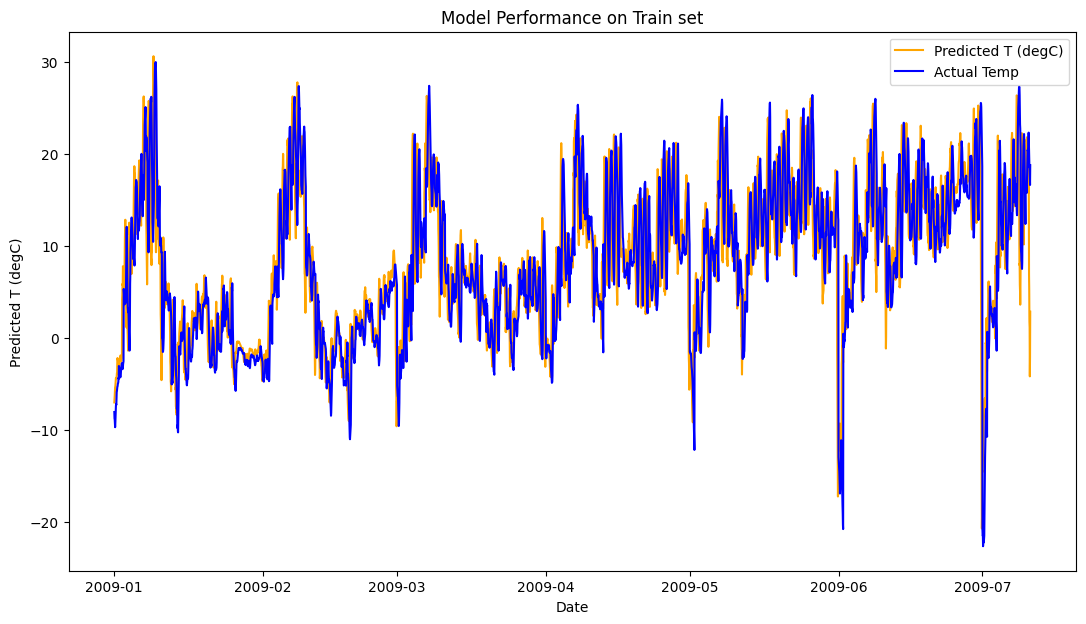

In [ ]:
# Train Plot

plot_sample = df1[(df1.index > '2009-01-01 00:00:00') & (df1.index < '2009-07-11 00:00:00')]
plot_sample_preds = train_preds_df[(train_preds_df['Date'] > '2009-01-01 00:00:00') & (train_preds_df['Date'] < '2009-07-11 00:00:00')]

plt.figure(figsize = (13, 7))
sns.lineplot(data = plot_sample_preds, x = 'Date', y = 'Predicted T (degC)', label = 'Predicted T (degC)', color = 'orange')
sns.lineplot(data = plot_sample.reset_index(), x = 'Date Time', y = 'T (degC)', label = 'Actual Temp', color = 'blue')
plt.title('Model Performance on Train set')
plt.show()

In [ ]:
train_mse, train_rmse = cnn_model.evaluate(train_generator)[0], cnn_model.evaluate(train_generator)[1]

print(f'''Mean Squared Error for train sample = {train_mse}
Root Mean Squared Error for train sample {train_rmse}''')

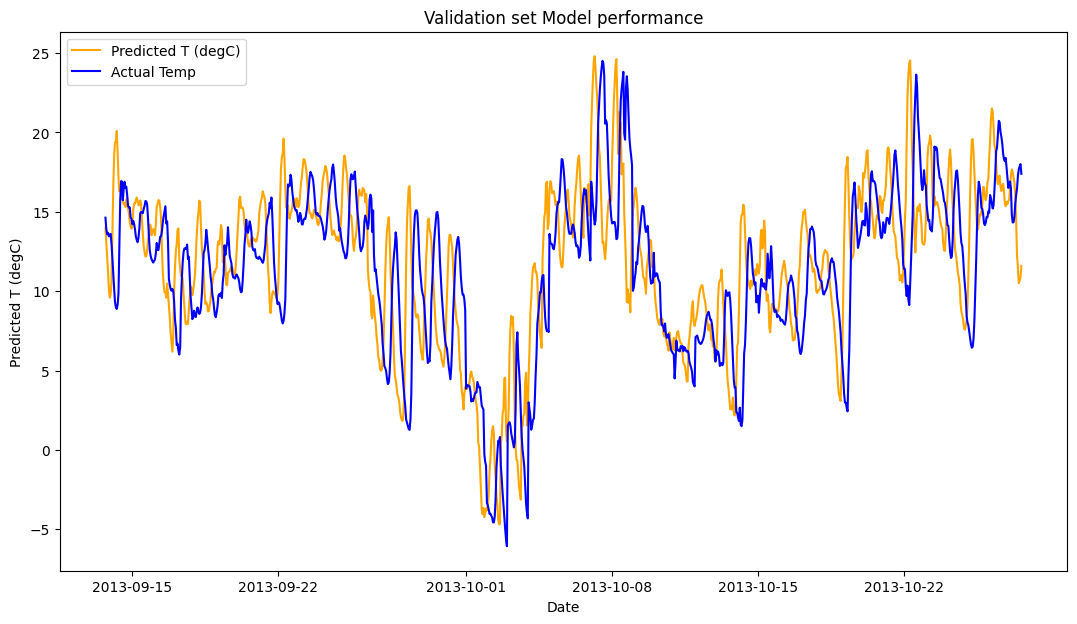

In [ ]:
# Validation Plot
val_df = df_no_null_1[train_len:-10]


plot_sample = val_df[(val_df.index > '2013-09-13 16:00:00') & (val_df.index < '2013-10-27 16:00:00')]
plot_sample_preds = val_preds_df[(val_preds_df['Date'] > '2013-09-13 16:00:00') & (val_preds_df['Date'] < '2013-10-27 16:00:00')]

plt.figure(figsize = (13, 7))
sns.lineplot(data = plot_sample_preds, x = 'Date', y = 'Predicted T (degC)', label = 'Predicted T (degC)', color = 'orange')
sns.lineplot(data = plot_sample.reset_index(), x = 'Date Time', y = 'T (degC)', label = 'Actual Temp', color = 'blue')
plt.title('Validation set Model performance')
plt.show()

In [20]:
val_mse, val_rmse = cnn_model.evaluate(val_generator)[0], cnn_model.evaluate(val_generator)[1]

print(f'''Mean Squared Error for Validation sample = {val_mse}
Root Mean Squared Error for Validation sample {val_rmse}''')

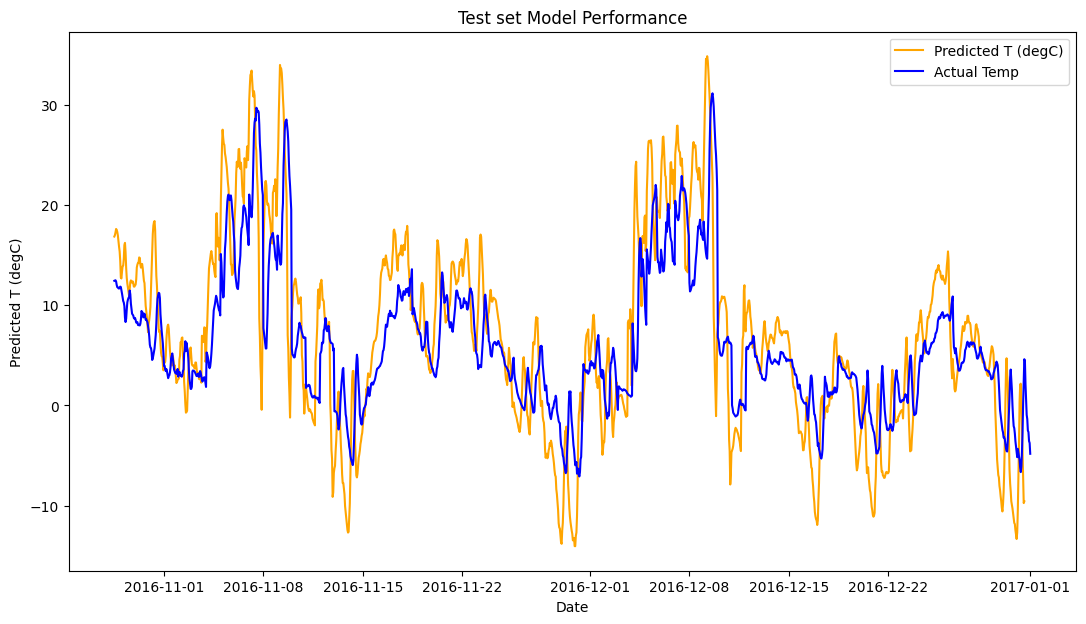

In [ ]:
# test Plot

plot_sample = test_df
plot_sample_preds = test_preds_df

plt.figure(figsize = (13, 7))
sns.lineplot(data = plot_sample_preds, x = 'Date', y = 'Predicted T (degC)', label = 'Predicted T (degC)', color = 'orange')
sns.lineplot(data = plot_sample.reset_index(), x = 'Date Time', y = 'T (degC)', label = 'Actual Temp', color = 'blue')
plt.title('Test set Model Performance')
plt.show()

In [21]:
test_mse, test_rmse = cnn_model.evaluate(test_generator)[0], cnn_model.evaluate(test_generator)[1]

print(f'''Mean Squared Error for test sample = {test_mse}
Root Mean Squared Error for test sample {test_rmse}''')